# Energy consumption prediction

## Import modules

In [2]:
import shap
import mlflow
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import time

from source.constants import MLFLOW_TRACKING_URI
from source.helpers import load_data, split_features_target
from source.preprocess import preprocess
from source.feature_selection import select_features

%load_ext autoreload
%autoreload 2

/Users/lin.yang/miniconda3/envs/aimd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mlflow.set_tracking_uri(f"file://{MLFLOW_TRACKING_URI}")
shap.initjs()

## Load and preprocess data

In [5]:
df_train, df_test = load_data()

Loading data...
Data have been loaded!
Train shape: (75757, 64)
Test shape: (9705, 63)


In [6]:
df_train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


##### Because the data set is big, with MLFlow, the produced files will be too large to be able to upload to the GitHub repository, here we will select the first 1000 instances of the training data set to train the model. Thus, the performance of our model will not be as good as one trained with full data set.

In [7]:
X, y = split_features_target(df_train)
X.drop("id", axis=1, inplace=True)
X.fillna(0, inplace=True)

Splitting data on features and target column 'site_eui'...
Data have been split!


### Perform train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
X_tr, X_tst = preprocess(X_train, X_test)
X_tr.shape, X_tst.shape

((68181, 62), (7576, 62))

In [10]:
new_features = select_features(X_tr, y_train)
print(new_features)

Index(['building_class_Residential', 'energy_star_rating', 'february_avg_temp',
       'march_min_temp', 'july_min_temp', 'july_avg_temp', 'october_max_temp',
       'november_min_temp', 'december_avg_temp', 'avg_temp'],
      dtype='object')


In [11]:
new_features = ['building_class_Residential', 'energy_star_rating', 'february_avg_temp',
       'march_min_temp', 'july_min_temp', 'july_avg_temp', 'october_max_temp',
       'november_min_temp', 'december_avg_temp', 'avg_temp']

## Models building
### Random Forest Tree Model

##### Because we have repeated patterns in numerical features. We decided to use random forest tree model. The random forest tree model can help us determine the importance of these features in the mean time of prediction.

In [12]:
mlflow.search_experiments()

[<Experiment: artifact_location='file:///Users/lin.yang/Documents/EPITA/Course/S2/AI%20Methodology/Project/github/energy-consumption_AIMethodology_2023-AIS/mlruns/930051040659533319', creation_time=1681573791737, experiment_id='930051040659533319', last_update_time=1681573791737, lifecycle_stage='active', name='Random Forest Experiment', tags={}>,
 <Experiment: artifact_location=('file:///Users/lin.yang/Documents/EPITA/Course/S2/AI '
  'Methodology/Project/github/energy-consumption_AIMethodology_2023-AIS/mlruns/895323239743716977'), creation_time=1681570886919, experiment_id='895323239743716977', last_update_time=1681570886919, lifecycle_stage='active', name='random_forest_estimator', tags={}>,
 <Experiment: artifact_location='file://d:\\master\\s2\\AI_meth\\energy-consumption-AIMethodology-2023-AIS\\mlruns/765894800488074784', creation_time=1681567067200, experiment_id='765894800488074784', last_update_time=1681567067200, lifecycle_stage='active', name='linear_regression', tags={}>,
 

In [14]:
# exp_id = mlflow.create_experiment('random_forest_estimator')
# exp_id = '960671181417565762'
exp_id = 895323239743716977

In [15]:
estimator = RandomForestRegressor(n_jobs=-1)

In [16]:
def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
  rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
  return round(rmsle, precision)

In [19]:
# mlflow.set_experiment("random_forest_estimator")
def train_estimator(estimator, _X_train, _y_train, _X_test, _y_test):
    
    with mlflow.start_run(experiment_id=exp_id):
        estimator.fit(_X_train, _y_train)
        y_pred = estimator.predict(_X_test)
        mse = mean_squared_error(_y_test, y_pred)
        rmsle = compute_rmsle(_y_test, y_pred)
        
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(_X_test, _y_test, approximate=True)
        
        plt.figure()
        shap.summary_plot(shap_values, _X_test, plot_type='bar')
        summary_plot1 = plt.gcf()
        time.sleep(1)
        summary_plot1.savefig('shap_summary_plot1.png')
        plt.show()
        
        plt.figure()
        shap.summary_plot(shap_values, _X_test)
        summary_plot2 = plt.gcf()
        time.sleep(1)
        summary_plot2.savefig('shap_summary_plot2.png')
        plt.show()
        
        mlflow.sklearn.log_model(estimator, 'estimator')
        mlflow.log_metrics({"testing_mse": mse, "testing_rmsle": rmsle})
        mlflow.log_artifact('shap_summary_plot1.png')
        mlflow.log_artifact('shap_summary_plot2.png')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


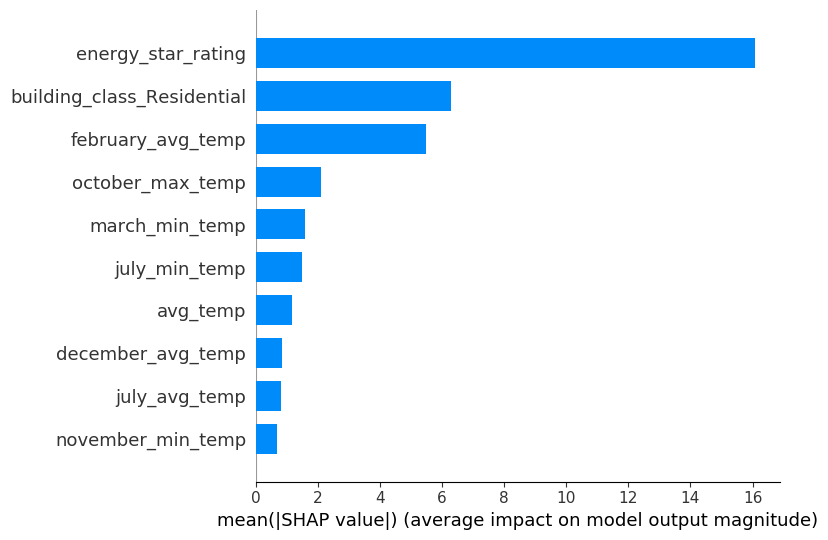

<Figure size 640x480 with 0 Axes>

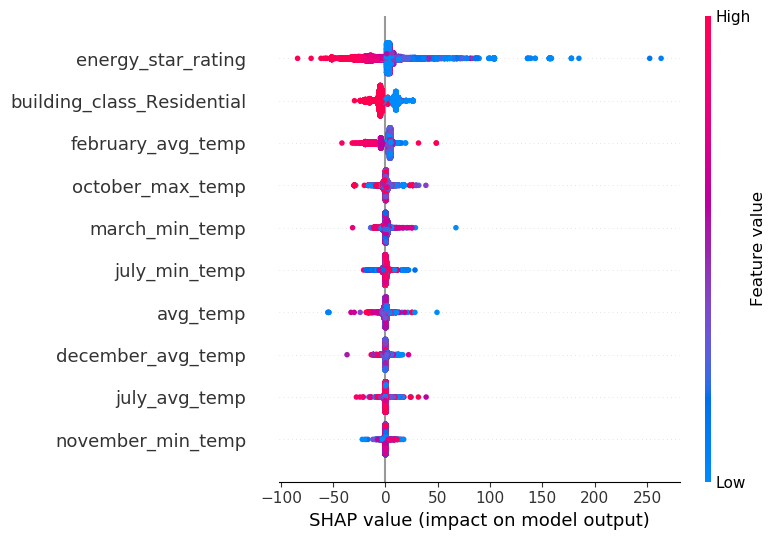

<Figure size 640x480 with 0 Axes>

In [20]:
X_train_num, X_test_num = X_tr[new_features], X_tst[new_features]
train_estimator(estimator, X_train_num, y_train, X_test_num, y_test)

## SHAP Model interpretation

In [81]:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X_test_num, y_test, approximate=True)

In [21]:
observation_idx = 0
shap.force_plot(explainer.expected_value, shap_values[observation_idx, :], X_test_num.iloc[observation_idx, :])